In [1]:
!pip install ipympl
!pip install brian2

In [2]:
%matplotlib inline
from brian2 import *
from scipy import stats
import numpy as np

#Animation libraries
import matplotlib.animation as ani
import matplotlib

## Notes

### Tables

![image](../images/Table_1.png)

![image](../images/Table_2.png)

![image](../images/Table_3.png)

### Units and SI Units

| Quantity         | Name     | Symbol |
|------------------|----------|-------:|
| Length           | Meter    |    $m$ |
| Mass             | Kilogram |   $kg$ |
| Time             | Second   |    $s$ |
| Electric Current | Ampere   |    $A$ |

| Quantity                                 | Name    |   Symbol |    Derivation |                                          Units |
|------------------------------------------|---------|---------:|--------------:|-----------------------------------------------:|
| Frequency                                | Hertz   |     $Hz$ |               |                                       $s^{-1}$ |
| Electric Charge, Quantity of electricity | Coulomb |      $C$ |               |                                    $s \cdot A$ |
| Electric Potential Difference            | Volt    |      $V$ | $\frac{W}{A}$ |       $m^2 \cdot kg \cdot s^{-3} \cdot A^{-1}$ |
| Electric Resistance                      | Ohm     | $\Omega$ | $\frac{V}{A}$ |       $m^2 \cdot kg \cdot s^{-3} \cdot A^{-2}$ |
| Electric Conductance                     | Siemens |      $S$ | $\frac{A}{V}$ | $m^{-2} \cdot kg^{-1} \cdot s^{3} \cdot A^{2}$ |

- $g_L$: The passive conductance of the leak channel (gL) in units of siemens/cm^2
  - $S / cm^2$
- $E_L$: The reversal potential of the leak channel in units of volts (V).
  - $V$
- $E_s$: The reversal potential of the synaptic conductance in units of volts (V).
  - $V$
- $I_m$: The current density due to the leak channel in units of amps/meter^2.
  - $A / cm^2$
- $I_s$: The synaptic current density in units of amps/meter^2.
  - $A / cm^2$
- $g_s$: The synaptic conductance in units of siemens.
  - $S$

### Grid Dimensions & Passive Channels

- Somatic Membrane Resistance : $R_{ms} = 680 \cdot ohms \cdot cm^2$
- Dendritic Membrane Resistance : $R_{md} = 34,200 \cdot ohms \cdot cm^2$
- Membrane Capacitance : $C_{m} = 1 * uF \cdot cm^{-2}$
- Somatic axial resistance : $R_{i} = 530 \cdot ohms \cdot cm$
- Dendritic axial resistance : $R_{i} = 530 \cdot ohms \cdot cm$
- Conductance between soma and apica dendrite : $g_{c\_ds} = 1.43e^{-5} \cdot ms$
- Membrane leakage conductance for soma : $g_{ms\_L} = 1.47 \cdot ms \cdot cm^{-2}$
- Membrane leakage conductance for dendrite : $g_{ms\_L} : 0.029 \cdot ms \cdot cm^{-2}$

Channel conductances : 
- $g_{NMDA} = 4.43 \cdot ms \cdot cm^{-2}$
- $g_{KDR} = 67 \cdot ms \cdot cm^{-2}$

Reversal potentials : 
- $E_{NMDA} = 0 \cdot mV$
- $E_{K} = -60 \cdot mV$
- $E_{L_d} = -58 \cdot mV$
- $E_{L_s} = -58 \cdot mV$

Transmembrane Potentials : 
$$C_m \frac{d V_{m\_d}}{dt} = - I_{NMDA} - I_{KDR} - I_{L_d} - \frac{g_{c\_sd}}{A_d}(V_{m\_d} - V_{m\_s})$$
$$C_m \frac{d V_{m\_s}}{dt} = - I_{L_s} - \frac{g_{c\_sd}}{A_s}(V_{m\_d} - V_{m\_s})$$

Gate dynamics : 
$$\frac{dn}{dt} = \alpha_n (V_{m\_d}) - n(\alpha_n (V_{m\_d}) + \beta_n (V_{m_d}))$$

$$B(V_{m\_d}) = \frac{1}{1 + \frac{[\text{Mg}^{2+}]_o}{M_o} \text{exp}(-k_B V_{m\_d})}$$

Variable rate functions : 
$$\alpha_n = \frac{0.00049 \times (V_{m\_d} - 32)}{1.0 - \exp{(- \frac{V_{m\_d} - 32}{25.0}})}$$
$$\beta_n = \frac{0.00008 \times (V_{m\_d} - 42.0)}{\exp{(- \frac{V_{m\_d} - 42.0}{10.0}}) - 1.0}$$

Potential of the electrical field : 
$$\varphi = \frac{\rho}{4 \pi r} \cdot I$$

Extracellular potential at two compartiments : 
$$V_{(k,l)\_e\_z} = SF \times \frac{\rho}{4 \pi r} \Sigma_{(i,j)} ( \frac{I_{(i,j)\_\text{tran\_d}}}{r_{(i,j)\_d\rarr(k,l)\_z}} + \frac{I_{(i,j)\_\text{tran\_s}}}{r_{(i,j)\_s\rarr(k,l)\_z}})$$

## Modelisation

### Utilities Function

In [3]:
def printInfoAtTime(msTime, neuronNum = 150):

    v_dend_increase = StateM[neuronNum].v_dend[msTime] - StateM[neuronNum].v_dend[msTime - 1] if StateM[neuronNum].v_dend[msTime - 1] == 0 else divide(StateM[neuronNum].v_dend[msTime] - StateM[neuronNum].v_dend[msTime - 1], StateM[neuronNum].v_dend[msTime - 1])*100
    v_soma_increase = StateM[neuronNum].v_soma[msTime] - StateM[neuronNum].v_soma[msTime - 1] if StateM[neuronNum].v_soma[msTime - 1] == 0 else divide(StateM[neuronNum].v_soma[msTime] - StateM[neuronNum].v_soma[msTime - 1], StateM[neuronNum].v_soma[msTime - 1])*100
    v_field_dd_tot_increase = StateM[neuronNum].v_field_dd_tot[msTime] - StateM[neuronNum].v_field_dd_tot[msTime - 1] if StateM[neuronNum].v_field_dd_tot[msTime - 1] == 0 else divide(StateM[neuronNum].v_field_dd_tot[msTime] - StateM[neuronNum].v_field_dd_tot[msTime - 1], StateM[neuronNum].v_field_dd_tot[msTime - 1])*100
    v_field_ds_tot_increase = StateM[neuronNum].v_field_ds_tot[msTime] - StateM[neuronNum].v_field_ds_tot[msTime - 1] if StateM[neuronNum].v_field_ds_tot[msTime - 1] == 0 else divide(StateM[neuronNum].v_field_ds_tot[msTime] - StateM[neuronNum].v_field_ds_tot[msTime - 1], StateM[neuronNum].v_field_ds_tot[msTime - 1])*100
    I_syn_dend_increase = StateM[neuronNum].I_syn_dend[msTime] - StateM[neuronNum].I_syn_dend[msTime - 1] if StateM[neuronNum].I_syn_dend[msTime - 1] == 0 else divide(StateM[neuronNum].I_syn_dend[msTime] - StateM[neuronNum].I_syn_dend[msTime - 1], StateM[neuronNum].I_syn_dend[msTime - 1])*100
    I_syn_soma_increase = StateM[neuronNum].I_syn_soma[msTime] - StateM[neuronNum].I_syn_soma[msTime - 1] if StateM[neuronNum].I_syn_soma[msTime - 1] == 0 else divide(StateM[neuronNum].I_syn_soma[msTime] - StateM[neuronNum].I_syn_soma[msTime - 1], StateM[neuronNum].I_syn_soma[msTime - 1])*100
    tot_pot_dend_increase = StateM[neuronNum].tot_pot_dend[msTime] - StateM[neuronNum].tot_pot_dend[msTime - 1] if StateM[neuronNum].tot_pot_dend[msTime - 1] == 0 else divide(StateM[neuronNum].tot_pot_dend[msTime] - StateM[neuronNum].tot_pot_dend[msTime - 1], StateM[neuronNum].tot_pot_dend[msTime - 1])*100
    tot_pot_soma_increase = StateM[neuronNum].tot_pot_soma[msTime] - StateM[neuronNum].tot_pot_soma[msTime - 1] if StateM[neuronNum].tot_pot_soma[msTime - 1] == 0 else divide(StateM[neuronNum].tot_pot_soma[msTime] - StateM[neuronNum].tot_pot_soma[msTime - 1], StateM[neuronNum].tot_pot_soma[msTime - 1])*100

    print("v_dend is", StateM[neuronNum].v_dend[msTime],
          "increasing by ", v_dend_increase, "%")
    print("v_soma is", StateM[neuronNum].v_soma[msTime],
          "increasing by ", v_soma_increase, "%")
    print("v_field_dd_tot is", StateM[neuronNum].v_field_dd_tot[msTime],
          "increasing by ", v_field_dd_tot_increase, "%")
    print("v_field_ds_tot is", StateM[neuronNum].v_field_ds_tot[msTime],
          "increasing by ", v_field_ds_tot_increase, "%")
    print("I_syn_dend is", StateM[neuronNum].I_syn_dend[msTime],
          "increasing by ", I_syn_dend_increase, "%")
    print("I_syn_soma is", StateM[neuronNum].I_syn_soma[msTime],
          "increasing by ", I_syn_soma_increase, "%")
    print("tot_pot_dend is", StateM[neuronNum].tot_pot_dend[msTime],
          "increasing by ", tot_pot_dend_increase, "%")
    print("tot_pot_soma is", StateM[neuronNum].tot_pot_soma[msTime],
          "increasing by ", tot_pot_soma_increase, "%")
    

def all_neuron_animation_other_data(data, timeData, frameNum):
  rc('animation', html='jshtml')

  # fig, ax = plt.subplots()
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  vmax = np.max(data)
  vmin = -1 if np.min(data) < -1 else np.min(data)

  print("vmax is : ", vmax)
  print("vmin is : ", vmin)

  cmap = matplotlib.pyplot.get_cmap('plasma')

  plt.imshow(np.real(np.reshape(data[:, 0], (cols, rows))), cmap=cmap)
  plt.colorbar(ticks=np.arange(vmin, vmax, 0.01))
  plt.clim(vmin, vmax)

  def buildmebarchart(i=int):
    frameNum = i
    ax.set_title("Frame"+str(i))
    ax.plot(timeData[0: frameNum],
            data[0: frameNum], label='v_soma')
    plt.imshow(
        np.real(np.reshape(data[:, frameNum], (cols, rows))), cmap=cmap)

  animator = ani.FuncAnimation(
      fig, buildmebarchart, frames=frameNum, interval=150, blit=False)

  # plt.show()
  return animator

def all_neuron_animation(data, timeData, frameNum):
  rc('animation', html='jshtml')

  # fig, ax = plt.subplots()
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  vmax = -0.08
  vmin = -0.01

  print("vmax is : ", vmax)
  print("vmin is : ", vmin)

  cmap = matplotlib.pyplot.get_cmap('plasma')

  plt.imshow(np.real(np.reshape(data[:, 0], (cols, rows))), cmap=cmap)
  plt.colorbar(ticks=np.arange(vmin, vmax, 0.001))
  plt.clim(vmin, vmax)

  def buildmebarchart(i=int):
    frameNum = i
    ax.set_title("Frame"+str(i))
    ax.plot(timeData[0: frameNum],
            data[0: frameNum], label='v_soma')
    plt.imshow(
        np.real(np.reshape(data[:, frameNum], (cols, rows))), cmap=cmap)

  animator = ani.FuncAnimation(
      fig, buildmebarchart, frames=frameNum, interval=150, blit=False)

  # plt.show()
  return animator


### Brian Modelisation

In [4]:
start_scope()

# Global Values
rows, cols = 200, 18
tau = 10*ms
tau_rp = 2 * ms

# Morphology
diameter_s = 15.8*umeter
diameter_d = 4.9*um
length_d = 336*um - diameter_d

# voltage
V_L = -70. * mV
V_thr = -50. * mV
V_reset = -55. * mV

# Membrane resistance
r_ms = 680 * ohm * cm**2
r_md = 34200 * ohm * cm**2
r_i = 530 * ohm * cm**2

# Membrane capacitance
C_m = 1 * uF

# Conductance between soma and dendrite
g_c_ds = 0.0000143 * msiemens
area_d = pi*(((4.9*umeter)/2)**2)/(meter**2)
area_s = pi*(((15.8*umeter)/2)**2)/(meter**2)

# Membrane leak
g_m_s_leak = 1.47 * nS
g_m_d_leak = 0.029 * nS

# Channels conductance
gNMDA = 4.43 * nS
gKDR = 67. * nS
EL_d = -58.*mV
EL_s = -58.*mV
ENMDA = 0.*mV
EKDR = -60.*mV

# Refractory periods
tau_g = 2 * ms
tau_leak = 2. * ms
tau_nmda = 4. * ms
tau_kdr = 1. * ms

# # NMDA (excitatory)
# tau_NMDA_rise = 2. * ms
# tau_NMDA_decay = 100. * ms
# alpha = 0.5 / ms
Mg2 = 1.

# Maxwell variables
rho = 300*ohm*cmeter
# SF_factor = 20 #ranges from 10 to 30
SF_factor = 1
max_factor = SF_factor * (rho / (4*pi))
dd_distance = 18.64 * umetre
ds_distance = 250.69 * umetre

eqs = '''
dv_dend/dt = ((I_syn_dend - ((g_c_ds/area_d) * tot_pot_dend))/ C_m) + (v_field_dd_tot/tau) : volt (unless refractory)
dv_soma/dt = ((I_syn_soma - ((g_c_ds/area_s) * tot_pot_soma))/ C_m) + (v_field_dd_tot/tau) : volt (unless refractory)

tot_pot_dend = v_dend - v_soma : volt
tot_pot_soma = v_soma - v_dend : volt

v_field_dd_tot: volt
v_field_ds_tot: volt

I_syn_dend = - I_leak_d -  I_nmda - I_kdr : amp
I_syn_soma = - I_leak_s : amp

I_leak_d = g_m_d_leak*(v_dend - EL_d) : amp
I_leak_s = g_m_s_leak*(v_soma - EL_s) : amp
I_nmda = gNMDA*B*(v_dend - ENMDA): amp
I_kdr = gKDR*(n**4)*(v_dend - EKDR) : amp

dn/dt = 2*((alpha_n * (v_dend/volt)) - (n * ((alpha_n * (v_dend/volt)) + (beta_n * (v_dend/volt)))))/(1*ms) : 1
alpha_n = (0.00049 * ((v_dend/volt) - 32.0)/(1.0 - e**(-((v_dend/volt) - 32.0)/25.0))) : 1
beta_n = (0.00008 * ((v_dend/volt) - 42.0)/(e**((((v_dend/volt) - 42.0)/10.0))-1.0)) : 1

B = 1/ (1 + (Mg/M_0)*e**(-0.062 * v_dend/volt)): 1
Mg = 1. * mmolar : mmolar
M_0 = 0.00357 * mmolar : mmolar

x : meter
y : meter
'''

reset_eqs = '''
v_soma = V_reset
v_dend = V_reset
'''

G = NeuronGroup(rows*cols, eqs, method='euler',
                threshold="v_soma > V_thr", reset=reset_eqs, refractory=tau_rp)

G.v_dend = V_L
G.v_soma = V_L

# initialize the grid positions
neuron_spacing = 18.64*umeter
G.x = '((i // rows)) * neuron_spacing'
G.y = '((i % rows)) * neuron_spacing'

syn_eqs='''
current_dd_distance = (dd_distance * (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2)/meter)) : meter
current_ds_distance = sqrt(((current_dd_distance)**2) + ((250*umetre)**2)): meter

v_field_dd_tot_pre = max_factor * v_field_dd: volt (summed)
v_field_dd = (I_syn_dend/current_dd_distance) + (I_syn_soma/current_ds_distance): amp/meter

v_field_ds_tot_pre = max_factor * v_field_ds: volt (summed)
v_field_ds = (I_syn_dend/current_ds_distance) + (I_syn_soma/current_dd_distance): amp/meter

w : 1
'''

# on_pre code is executed at each synapse receiving a presynaptic spike
# on_post code is executed at each synapse receiving a postsynaptic spike
S = Synapses(G, G, model=syn_eqs, method='euler')
S.connect('j != i')
# S[:].w = "300*umetre/(4*pi*sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2)) + i/20"
S[:].w = 1

print("Connection done")

StateM = StateMonitor(G, True, record=True)
SpikeM = SpikeMonitor(G)
PopRateM = PopulationRateMonitor(G)
  # Selecting neuron populations by columns
PopRateSels = [PopulationRateMonitor(G[pi:pi + 10])
            for pi in range(0, rows*cols, rows)]

print("State monitoring done")

# monitors
N_activity_plot = 15
p = 5

print("Running Start")

net = Network(collect())
net.add(StateM)
net.add(SpikeM)
net.add(PopRateM)
net.add(PopRateSels)
net.run(0.01 * second, report='stdout')

print("Running done")

Connection done
State monitoring done
Running Start
Starting simulation at t=0. s for a duration of 10. ms
1.4 ms (13%) simulated in 10s, estimated 1m 5s remaining.
2.8 ms (27%) simulated in 20s, estimated 54s remaining.
4.1 ms (41%) simulated in 31s, estimated 45s remaining.
5.4 ms (54%) simulated in 41s, estimated 35s remaining.
6.7 ms (67%) simulated in 51s, estimated 25s remaining.
8. ms (80%) simulated in 1m 1s, estimated 15s remaining.
9.4 ms (94%) simulated in 1m 11s, estimated 5s remaining.
10. ms (100%) simulated in 1m 16s
Running done


In [5]:
printInfoAtTime(int(100*0.011))
print("-"*20)
printInfoAtTime(int(100*0.012))

v_dend is -68.82275341 mV increasing by  -1.681780847323372 %
v_soma is -68.82275179 mV increasing by  -1.6817831607006988 %
v_field_dd_tot is 117.72464485 mV increasing by  117.72464485 mV %
v_field_ds_tot is 1.43505246 V increasing by  1.43505246 V %
I_syn_dend is 1.39382503 pA increasing by  -3.6321277082990155 %
I_syn_soma is 15.90944513 pA increasing by  -9.81040177075408 %
tot_pot_dend is -1.61936413 nV increasing by  -1.61936413 nV %
tot_pot_soma is 1.61936413 nV increasing by  1.61936413 nV %
--------------------
v_dend is -68.82275341 mV increasing by  -1.681780847323372 %
v_soma is -68.82275179 mV increasing by  -1.6817831607006988 %
v_field_dd_tot is 117.72464485 mV increasing by  117.72464485 mV %
v_field_ds_tot is 1.43505246 V increasing by  1.43505246 V %
I_syn_dend is 1.39382503 pA increasing by  -3.6321277082990155 %
I_syn_soma is 15.90944513 pA increasing by  -9.81040177075408 %
tot_pot_dend is -1.61936413 nV increasing by  -1.61936413 nV %
tot_pot_soma is 1.61936413 n

### Graph Analysis

#### Checking x/y positions

In [6]:
x_list = np.real(np.array((StateM.x/neuron_spacing).tolist()))
y_list = np.real(np.array((StateM.y/neuron_spacing).tolist()))
cmap = matplotlib.pyplot.get_cmap('plasma')


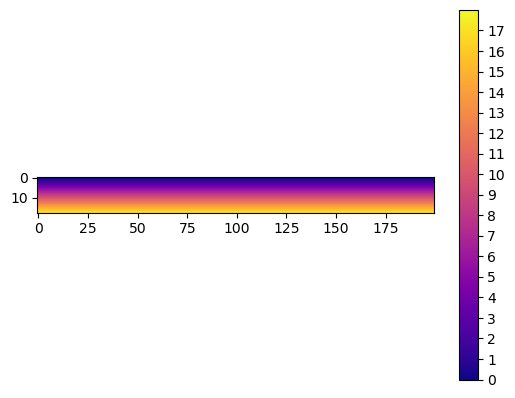

In [7]:

vmax = cols
vmin = 0

plt.imshow(
    np.real(np.reshape(x_list[:, 0], (cols, rows))), cmap=cmap)
plt.colorbar(ticks=np.arange(vmin, vmax, 1))
plt.clim(vmin, vmax)



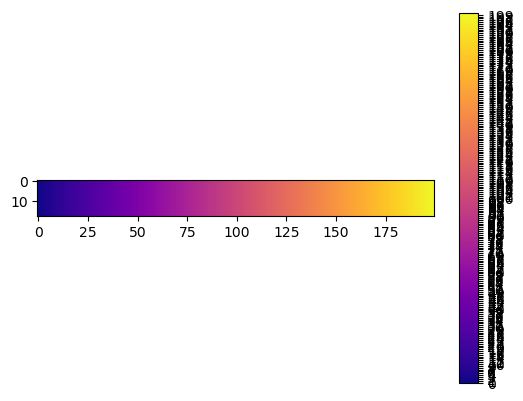

In [8]:
vmax = rows
vmin = 0

plt.imshow(np.real(np.reshape(y_list[:, 0], (cols, rows))), cmap=cmap)
plt.colorbar(ticks=np.arange(vmin, vmax, 1))
plt.clim(vmin, vmax)


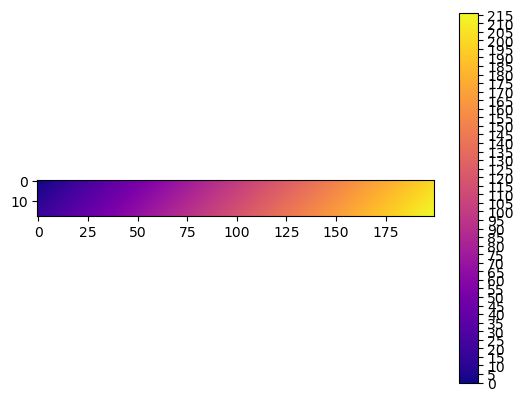

In [9]:
data = y_list[:, 0] + x_list[:, 0]

vmax = np.max(data)
vmin = 0

plt.imshow(np.real(np.reshape(data, (cols, rows))), cmap=cmap)
plt.colorbar(ticks=np.arange(vmin, vmax, 5))
plt.clim(vmin, vmax)


vmax is :  -0.08
vmin is :  -0.01


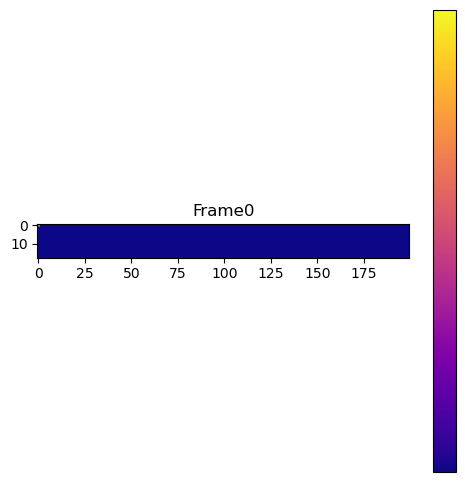

In [38]:
data = np.array(StateM.v_soma.tolist())
time = StateM.t
numberOfFrames = int(len(time)/2)

#Animation showing the soma potential for all neurons during the experiment lifetime
animm = all_neuron_animation(data, time, numberOfFrames)
animm.save("../animations/fullAnimation_200_18__vSoma_NoSF.gif")
animm


vmax is :  0.32673429233959184
vmin is :  -1


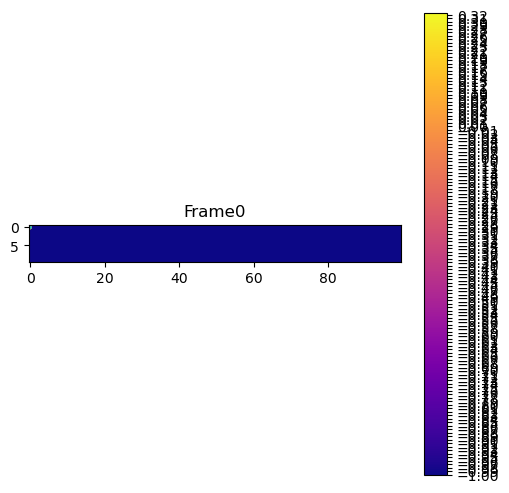

In [12]:
data = np.array(StateM.v_field_dd_tot.tolist()) - np.array(StateM.v_field_ds_tot.tolist())
time = StateM.t
numberOfFrames = int(len(time)/2)

# Animation showing the soma potential for all neurons during the experiment lifetime
animm = all_neuron_animation_other_data(data, time, numberOfFrames)
animm
# animm.save("../animations/fullAnimation_100_10.gif")


#### Potential activity

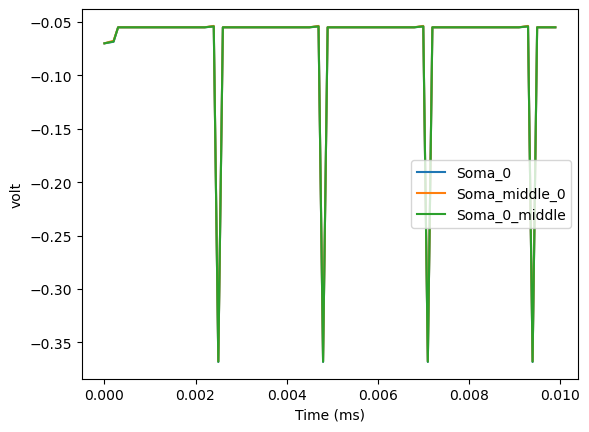

In [50]:
  # A neuron on the corner : i = 0
plot(np.array(StateM.t), StateM[0].v_soma, label='Soma_0')
  
  # A neuron on the first row, middle column : i = 0
index_middle_0 = int(np.floor(rows / 2))
plot(np.array(StateM.t), StateM[index_middle_0].v_soma, label='Soma_middle_0')

  # A neuron on the first column, in the middle row : i = 0
index_0_middle = int(np.floor(cols / 2) * rows)
plot(np.array(StateM.t), StateM[index_0_middle].v_soma, label='Soma_0_middle')

  # A neuron on the middle of the stack : i = 0
index_middle_middle = index_0_middle + index_middle_0
plot(np.array(StateM.t),StateM[index_middle_middle].v_soma, label='Soma_middle_middle')

xlabel('Time (ms)')
ylabel('volt')
legend()


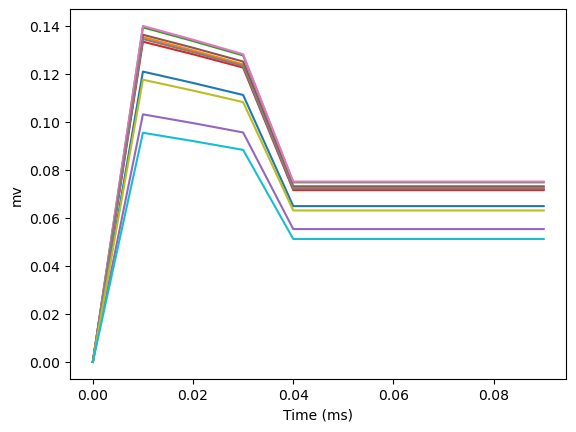

In [40]:
def plotTimeFunction(minMs, maxMs, neuronNumber):

    numberOfNeurons = rows * cols

    index = 0

    for i in range(neuronNumber):
        index += int(np.divide(numberOfNeurons, neuronNumber))-1

        # plot(StateM.t[minMs: maxMs]/tau,
        #      StateM[index].v_dend[minMs: maxMs], label='v_dend')
        # plot(StateM.t[minMs: maxMs]/tau,
        #      StateM[index].v_soma[minMs: maxMs], label='v_soma_'+str(index))
        # plot(StateM.t[minMs: maxMs]/tau,
        #      StateM[index].v_field_ds_tot[minMs: maxMs], label='v_field_ds_tot')
        plot(StateM.t[minMs: maxMs]/tau,
             StateM[index].v_field_dd_tot[minMs: maxMs], label='v_field_dd_tot')
    #     plot(StateM.t[minMs: maxMs]/tau, StateM[index].n[minMs: maxMs], label='n')
        # plot(StateM.t[minMs: maxMs]/tau, StateM[index].I_kdr[minMs: maxMs], label='I_kdr')
        # plot(StateM.t[minMs: maxMs]/tau, StateM[index].I_nmda[minMs: maxMs], label='I_nmda')
        # plot(StateM.t[minMs: maxMs]/tau, StateM[index].I_leak_d[minMs: maxMs], label='I_leak_d')
    #     plot(StateM.t[minMs: maxMs]/tau,
    #          StateM[index].tot_pot_dend[minMs: maxMs], label='tot_pot_dend')
    #     plot(StateM.t[minMs: maxMs]/tau,
    #          StateM[index].tot_pot_soma[minMs: maxMs], label='tot_pot_soma')
        # print(StateM[index].alpha_n[0])
        # print(StateM[index].beta_n[0])
    xlabel('Time (ms)')
    ylabel('mv')
    # legend()

# Plotting the first 10 milliseconds
minTime = int(1000*0.000)
rangeVal = 1*10
plotTimeFunction(minTime, minTime + rangeVal, 10)


<Figure size 640x480 with 0 Axes>

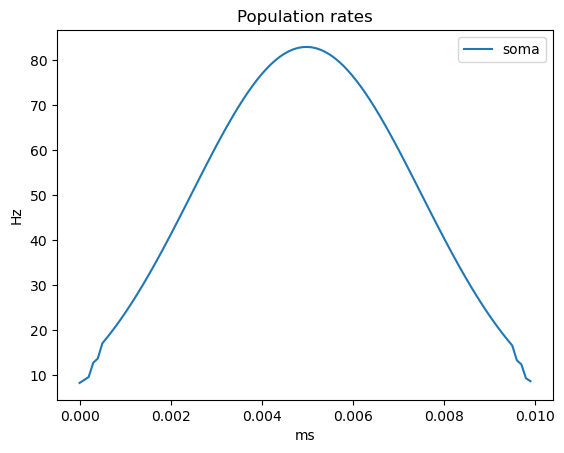

<Figure size 640x480 with 0 Axes>

In [47]:
title('Population rates')
xlabel('ms')
ylabel('Hz')

plot(PopRateM.t, PopRateM.smooth_rate(width=25 * ms)
     [1::10] / Hz, label='soma')
# plot(r_I.t / ms, r_I.smooth_rate(width=25 * ms) / Hz, label='dendrites')

# for i, PopRateSel in enumerate(PopRateSels[::-1]):
#     plot(PopRateSel.t / ms, PopRateSel.smooth_rate(width=25 * ms)[0::100][0:10] / Hz,
#          label=f"selective {p - i}")

legend()
figure()


<Figure size 640x480 with 0 Axes>

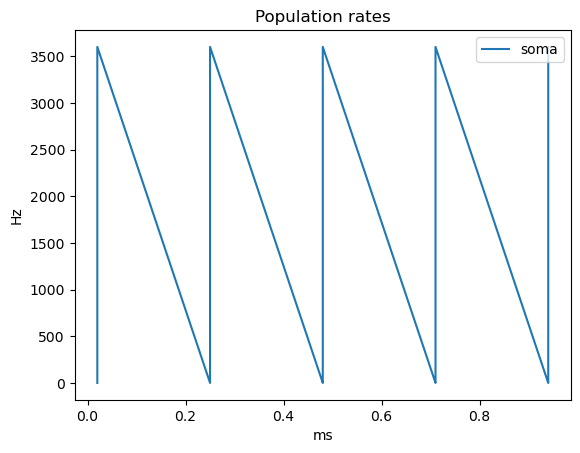

<Figure size 640x480 with 0 Axes>

In [48]:
title('Population rates')
xlabel('ms')
ylabel('Hz')

plot(SpikeM.t / tau, SpikeM.i, label='soma')
# plot(r_I.t / tau, r_I.smooth_rate(width=25 * ms) / Hz, label='dendrites')

legend()
figure()


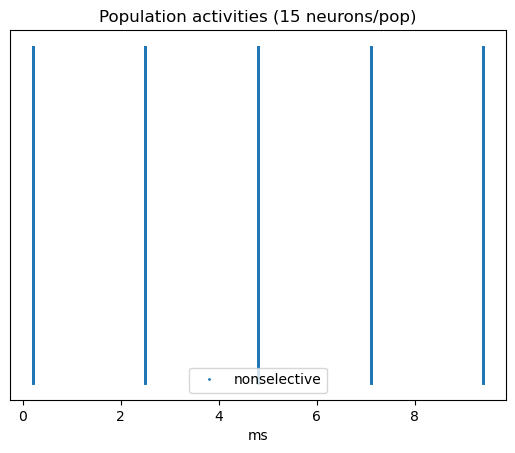

In [49]:
N_activity_plot = 15
p = 5

title(f"Population activities ({N_activity_plot} neurons/pop)")
xlabel('ms')
yticks([])

plot(SpikeM.t / ms, SpikeM.i + 5 * N_activity_plot, '.', markersize=2,
     label="nonselective")
# for i, PopRateSel in enumerate(PopRateSels[:15]):
#     plot(PopRateSel.t / ms, PopRateSel.i + (p - 1) * N_activity_plot, '.', markersize=2,
#          label=f"selective {p - i}")
    
legend()
show()


## Animations

In [42]:
import matplotlib.animation as ani
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation, PillowWriter


In [43]:
v_soma_list = np.array(StateM.v_soma.tolist())

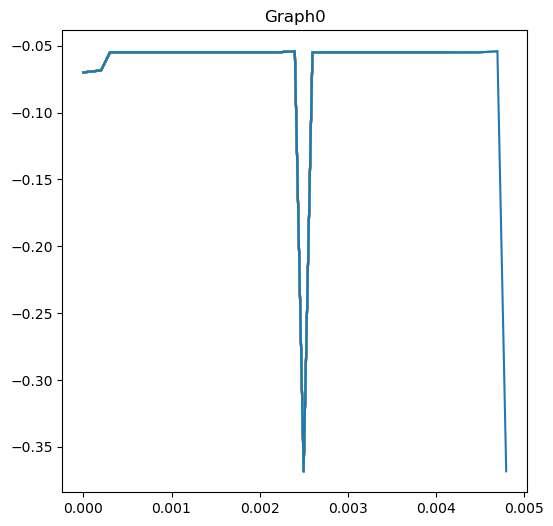

In [53]:
def launch_animation():
  rc('animation', html='jshtml')

  # fig, ax = plt.subplots()
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  # plt.imshow(np.real(np.reshape(voltage_data[0, :], (8, 8))), cmap=cmap)
  # plt.colorbar(ticks=np.arange(vmin, vmax, 0.1))
  # plt.clim(vmin, vmax)

  def buildmebarchart(i=int):
    ax.set_title("Graph"+str(i))
    ax.plot(StateM.t[0: i], StateM[0].v_soma[0: i], label='v_soma')

  animator = ani.FuncAnimation(
      fig, buildmebarchart, frames=50, interval=200, blit=False)

  # plt.show()
  return animator

plt.close()
launch_animation()


Running done


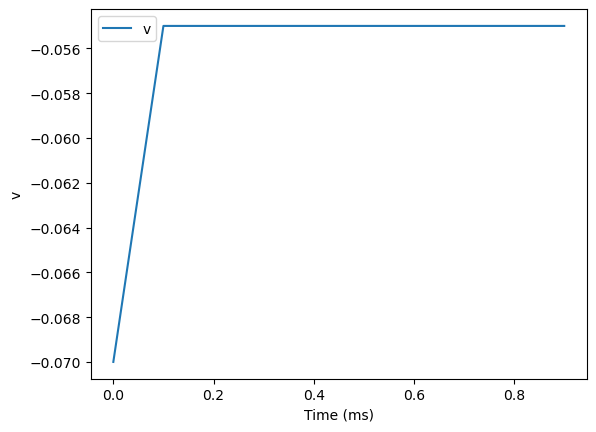

In [65]:
print("Running done")

plot(StateM.t/ms, StateM[150].v_soma, label='v')

xlabel('Time (ms)')
ylabel('v')
legend()


Text(0, 0.5, 'Firing rate (sp/s)')

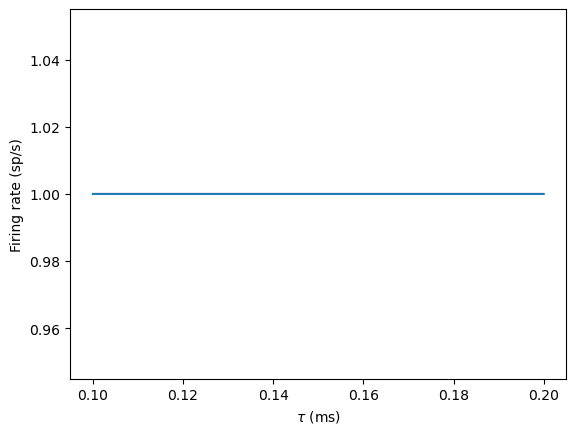

In [132]:
output_rates = SpikeM.count/second  # firing rate is count/duration
plot(SpikeM.t/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)')
